## Команда Яндекс Поиска проводит AB эксперимент с изменением логики показа рекламы.

По результатам эксперимента аналитики заметили, что сильно поменялись метрики ранжирования, которые не должны были поменяться в этом эксперименте. 

Разработчики подозревает, что баг в коде мог задеть рассчет некоторых фичей для формулы ранжирования. Причем этот баг никак не влияет на среднее и дисперсию распределения отдельных фичей, но затрагивает саму форму распределения.

**Нужно найти индексы фичей, которые были затронуты багом.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set(rc={'figure.figsize': (16.0, 4.0), 
            'axes.grid.axis': 'both',
            "grid.color": "lightgrey",
            'axes.facecolor':'white'})

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('C:/Users/obeya/analyst/portfolio_project/Yandex_an/featch/dataset.tsv', sep='\t', names=['n' ,'test_id', 'indx', 'feat'])

In [3]:
df.head()

,n,test_id,indx,feat
0,3,1,0,4.946383
1,15,1,0,5.094175
2,2,1,0,4.610773
3,7,1,0,4.733779
4,8,1,0,4.790034


### Есть файл логов со следующим содержанием:
    n - номер дня проведения АБ эксперимента
    test_id - номер выборки
    indx - индекс фичи в формуле ранжирования
    feat - значение фичи в формуле ранжирования

In [4]:
def desc(df):
    """ Функция выведет основные описательные статистики, а также типы данных и количество уникальных значений """
    ret_df = pd.concat([pd.DataFrame(
        df.describe(include='all')).T,
        pd.DataFrame([df.nunique().values, df.isna().sum().values], index=['nunique','isna']).T.set_index(df.columns),   
        pd.DataFrame(df.dtypes, columns=['dtypes'])],axis=1
                                      )
    return ret_df.replace(np.nan, '')

**Посмотрим  на формат, кол-во данных, пропусков и уникальных значений**

In [5]:
desc(df)

,count,mean,std,min,25%,50%,75%,max,nunique,isna,dtypes
n,30000000.0,7.999330e+00,4.320775e+00,1.000000e+00,4.000000,8.000000,12.000000,1.500000e+01,15,0,int64
test_id,30000000.0,1.500000e+00,5.000000e-01,1.000000e+00,1.000000,1.500000,2.000000,2.000000e+00,2,0,int64
indx,30000000.0,7.495000e+02,4.330126e+02,0.000000e+00,374.750000,749.500000,1124.250000,1.499000e+03,1500,0,int64
feat,30000000.0,4.106289e+14,2.244171e+18,-3.093026e+10,-1.699915,1.021568,5.881723,1.229182e+22,29990016,0,float64


**Найдем Среднее и Сигму для каждой фичи по вариантам**

In [6]:
mean_std_df = df.groupby(['test_id','indx']).agg({'feat':['mean','std']})

In [7]:
mean_std_df = mean_std_df.stack(0).reset_index()

In [8]:
mean_std_df.head()

,test_id,indx,level_2,mean,std
0,1,0,feat,4.880257,0.107158
1,1,1,feat,3.606224,13.966568
2,1,2,feat,2.216175,14.057105
3,1,3,feat,3.726099,3.773634
4,1,4,feat,-1.597642,2.083168


**Добавим значения к основному дата фрейму**

In [9]:
df_new = df.merge(mean_std_df, how= 'left', on = ['test_id','indx'])

In [10]:
mean_std_df = df_new

**Стандартизируем значения фичей**

In [10]:
df_new['std_feat']=(df_new['feat']  - df_new['mean']) / df_new['std']

In [11]:
df_new.head()

,n,test_id,indx,feat,level_2,mean,std,std_feat
0,3,1,0,4.946383,feat,4.880257,0.107158,0.617090
1,15,1,0,5.094175,feat,4.880257,0.107158,1.996280
2,2,1,0,4.610773,feat,4.880257,0.107158,-2.514824
3,7,1,0,4.733779,feat,4.880257,0.107158,-1.366936
4,8,1,0,4.790034,feat,4.880257,0.107158,-0.841958


**Найдем размах для каждой фичи по вариантам**

In [12]:
df_range = df_new.groupby(['test_id','indx']).agg({'std_feat':['max','min']})['std_feat'][['max']].values -\
df_new.groupby(['test_id','indx']).agg({'std_feat':['max','min']})['std_feat'][['min']].values

In [13]:
df_range = pd.DataFrame(df_range, columns=['range'])
df_range = pd.concat([mean_std_df[['test_id','indx']], df_range], axis=1)

In [14]:
df_new = df_new.merge(df_range, how= 'left', on = ['test_id','indx'])

In [15]:
df_new.head()

,n,test_id,indx,feat,level_2,mean,std,std_feat,range
0,3,1,0,4.946383,feat,4.880257,0.107158,0.617090,10.91591
1,15,1,0,5.094175,feat,4.880257,0.107158,1.996280,10.91591
2,2,1,0,4.610773,feat,4.880257,0.107158,-2.514824,10.91591
3,7,1,0,4.733779,feat,4.880257,0.107158,-1.366936,10.91591
4,8,1,0,4.790034,feat,4.880257,0.107158,-0.841958,10.91591


In [16]:
len(df_new)

30000000

**Посчитаем значения перцентилей для каждой фичи**

In [17]:
log_reg_df = df_new.groupby(['test_id','indx']).agg({'mean':max,
                                        'std':max,
                                        'range':max,            
                                        'std_feat': [
                                             lambda x : x.quantile(0.1),
                                             lambda x : x.quantile(0.2),
                                             lambda x : x.quantile(0.3),
                                             lambda x : x.quantile(0.4),
                                             lambda x : x.quantile(0.5),
                                             lambda x : x.quantile(0.6),
                                             lambda x : x.quantile(0.7),
                                             lambda x : x.quantile(0.8),
                                             lambda x : x.quantile(0.9),
                                             lambda x : x.quantile(0.10)
                                            ]})

In [18]:
new_df = pd.concat([log_reg_df['std'].rename(columns={'max':'std'}), 
           log_reg_df['mean'].rename(columns={'max':'mean'}),
           log_reg_df['range'].rename(columns={'max':'range'}),
           log_reg_df['std_feat']],axis=1)

In [19]:
new_df = new_df.reset_index()

In [20]:
new_df.head()

,test_id,indx,std,mean,range,<lambda_0>,<lambda_1>,<lambda_2>,<lambda_3>,<lambda_4>,<lambda_5>,<lambda_6>,<lambda_7>,<lambda_8>,<lambda_9>
0,1,0,0.107158,4.880257,10.915910,-1.199289,-0.751796,-0.468398,-0.222844,-0.007369,0.215174,0.464696,0.758393,1.206506,-1.199289
1,1,1,13.966568,3.606224,9.163255,-1.220135,-0.760465,-0.474948,-0.221974,0.000629,0.217707,0.463005,0.757695,1.213431,-1.220135
2,1,2,14.057105,2.216175,10.540384,-1.214868,-0.756489,-0.462590,-0.218783,0.010557,0.226367,0.471971,0.768790,1.214441,-1.214868
3,1,3,3.773634,3.726099,10.277356,-0.883509,-0.769970,-0.640624,-0.486691,-0.309502,-0.090127,0.199435,0.601860,1.271111,-0.883509
4,1,4,2.083168,-1.597642,7.181474,-1.271798,-0.823598,-0.527499,-0.249309,0.003572,0.247671,0.513915,0.826738,1.293527,-1.271798


**Найдем средний квадрат отклонений перцентилей для каждой пары вариантов фичей**

In [21]:
MSE_q = pd.DataFrame((new_df.iloc[:,5:].values[:1500] - new_df.iloc[:,5:].values[1500:])**2 / 10).sum(1).reset_index().rename(columns={'index':'indx', 0:"MSE_q"})

In [22]:
new_df = new_df.merge(MSE_q, how = 'left', on ='indx')

In [23]:
new_df.head(3)

,test_id,indx,std,mean,range,<lambda_0>,<lambda_1>,<lambda_2>,<lambda_3>,<lambda_4>,<lambda_5>,<lambda_6>,<lambda_7>,<lambda_8>,<lambda_9>,MSE_q
0,1,0,0.107158,4.880257,10.915910,-1.199289,-0.751796,-0.468398,-0.222844,-0.007369,0.215174,0.464696,0.758393,1.206506,-1.199289,0.000040
1,1,1,13.966568,3.606224,9.163255,-1.220135,-0.760465,-0.474948,-0.221974,0.000629,0.217707,0.463005,0.757695,1.213431,-1.220135,0.000141
2,1,2,14.057105,2.216175,10.540384,-1.214868,-0.756489,-0.462590,-0.218783,0.010557,0.226367,0.471971,0.768790,1.214441,-1.214868,0.000044


In [27]:
len(new_df)

3000

**Отсортируем по убыванию и возьмем первые 10 фичей с наибольшим MSE**

In [24]:
feat_bag = new_df.sort_values('MSE_q',ascending=False)['indx'][:22].unique()
feat_bag

array([ 988, 1401,  814, 1076,  709,  878, 1289,  940,  493,  677,  874],
      dtype=int64)

## Посмотри на различия в распределениях фичей визуально

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
mean_std_df.iloc[:3, :]

,n,test_id,indx,feat,level_2,mean,std
0,3,1,0,4.946383,feat,4.880257,0.107158
1,15,1,0,5.094175,feat,4.880257,0.107158
2,2,1,0,4.610773,feat,4.880257,0.107158


    Построим Lineplot Где
    X Порядковый номер значения фичи (непренципиально, можно взять random(0,1), 
    Y Стандартизированое значение фичи

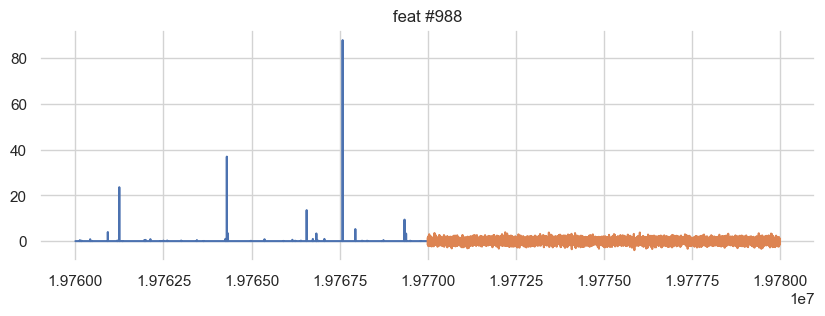

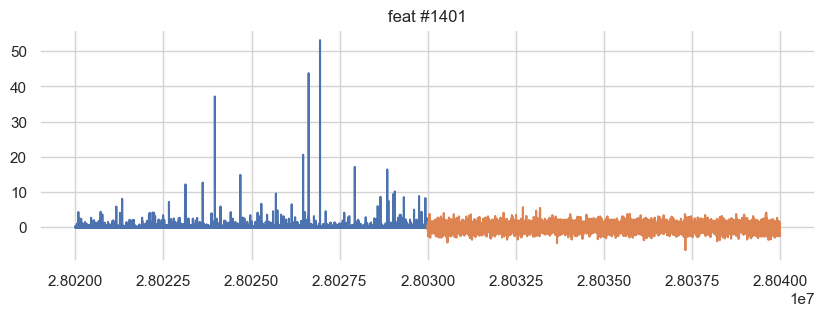

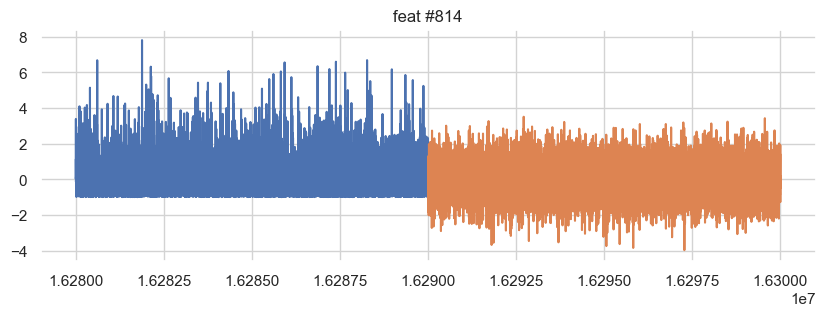

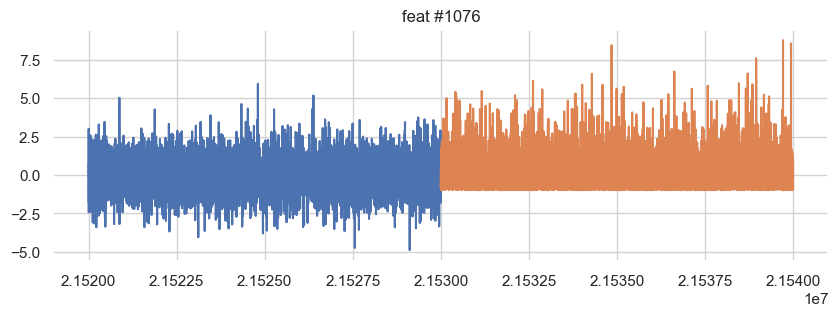

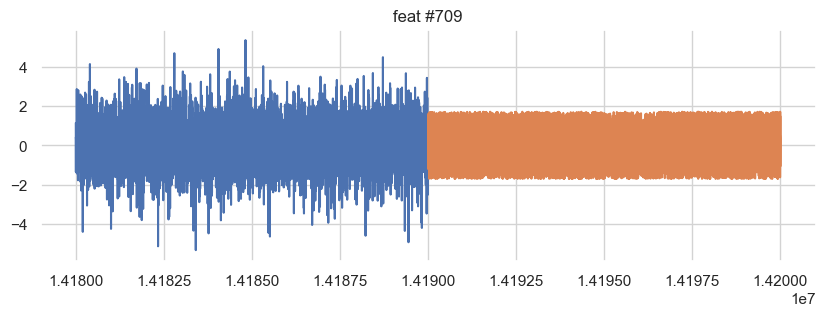

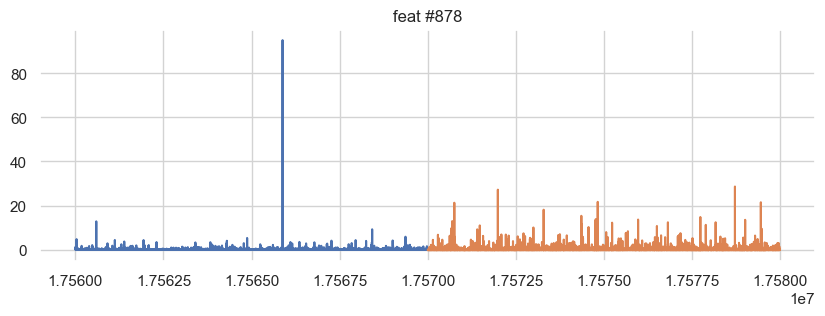

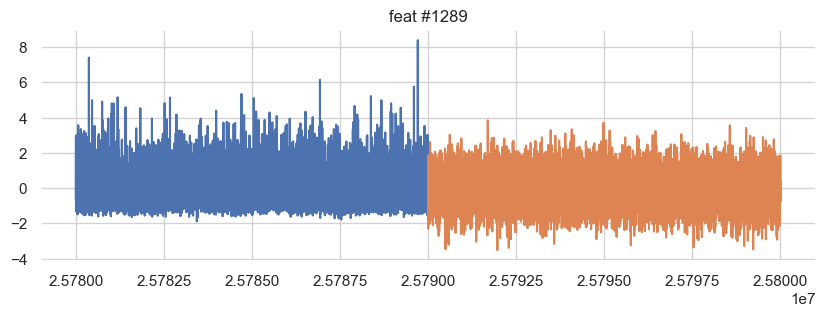

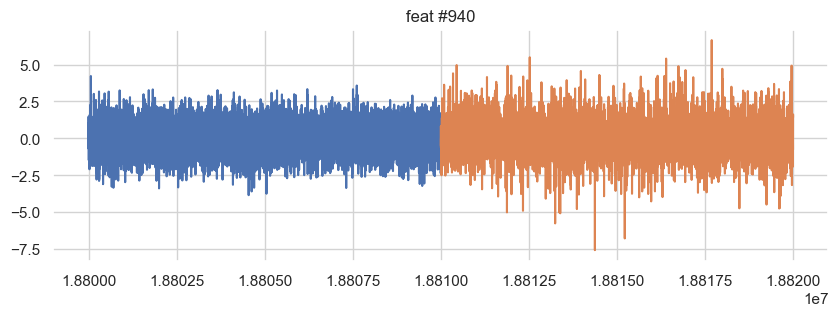

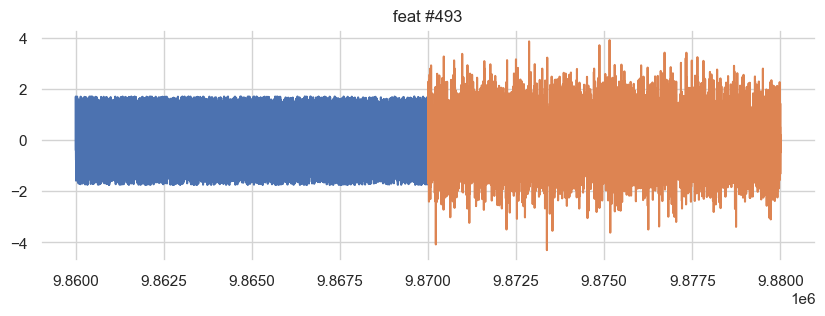

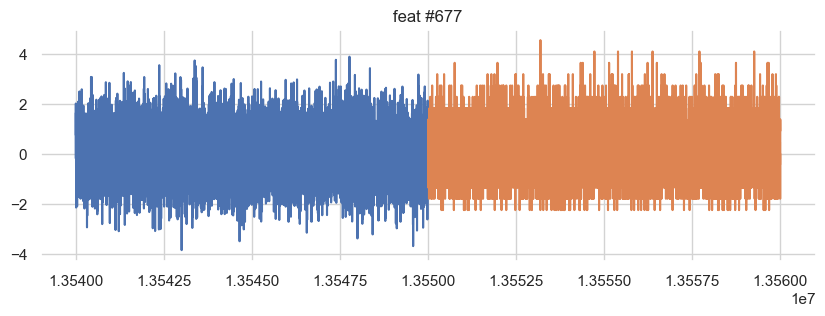

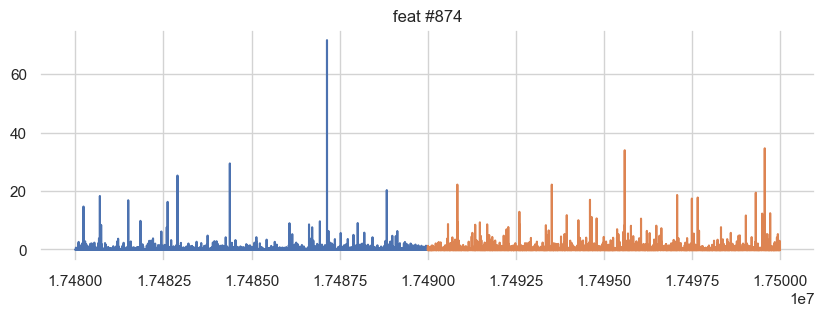

In [43]:
for i in feat_bag:
    plt.figure(figsize=(10,3))
    plt.title('feat #'+str(i))
    mean_std_df[(mean_std_df['indx'] == i) &  (mean_std_df['test_id'] == 1)].std_feat.plot()
    mean_std_df[(mean_std_df['indx'] == i) &  (mean_std_df['test_id'] == 2)].std_feat.plot()